In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [29]:
run_start = 1
run_number = 3
raw_runs = []
method = 'Trigger'
for i in range(run_start, run_start + run_number):
    with open(f"data/stress_{i}.json", "r") as f:
        raw_runs.append([json.loads(line) for line in f])

In [30]:
def prepare_dataframe(data):
    df = pd.json_normalize(data)

    df['timestamp'] = pd.to_datetime(df['data.time']).dt.floor('S')
    df['value'] = pd.to_numeric(df['data.value'])
    df = df[['timestamp', 'metric', 'value']].sort_values('timestamp')

    # df with only the columns needed and the timestamp as the index
    df = (df.pivot_table(index='timestamp', columns='metric', values='value', aggfunc='sum').fillna(0))

    t0 = df.index.min()
    t1 = df.index.max()

    # index in seconds instead of timestamps
    index_in_seconds = (df.index - t0).total_seconds().astype(int)
    df.index = index_in_seconds

    # fill up missing seconds (should not be needed but just in case)
    full_idx = pd.RangeIndex(start=0, stop=int((t1 - t0).total_seconds()) + 1, step=1, name='t_seconds')
    df = df.reindex(full_idx, fill_value=0)

    df['connections'] = df['single_client_connections'].cumsum()
    df['sent'] = df['single_client_msgs_sent'].cumsum()
    df['received'] = df['single_client_msgs_received'].cumsum()
    df['msg_delta'] = df['sent'] - df['received']

    # smooth out the delta
    delta = df['msg_delta']
    delta_med = delta.rolling(5, min_periods=1, center=True).median()
    df['msg_delta'] = delta_med

    return df

In [ ]:
def get_increase_point(df):
    delta = df['msg_delta'].sort_index()
    window = 5
    dwell = 3
    gain = delta - delta.shift(dwell)
    increased = gain.ge(9)
    streak = increased.rolling(dwell, min_periods=dwell).sum().ge(dwell)

    if not streak.any():
        return None

    end_t = streak.idxmax()
    start_t = end_t - (window - 1) - (dwell - 1)
    return int(start_t)

[222.0, 222.0, 213.0]


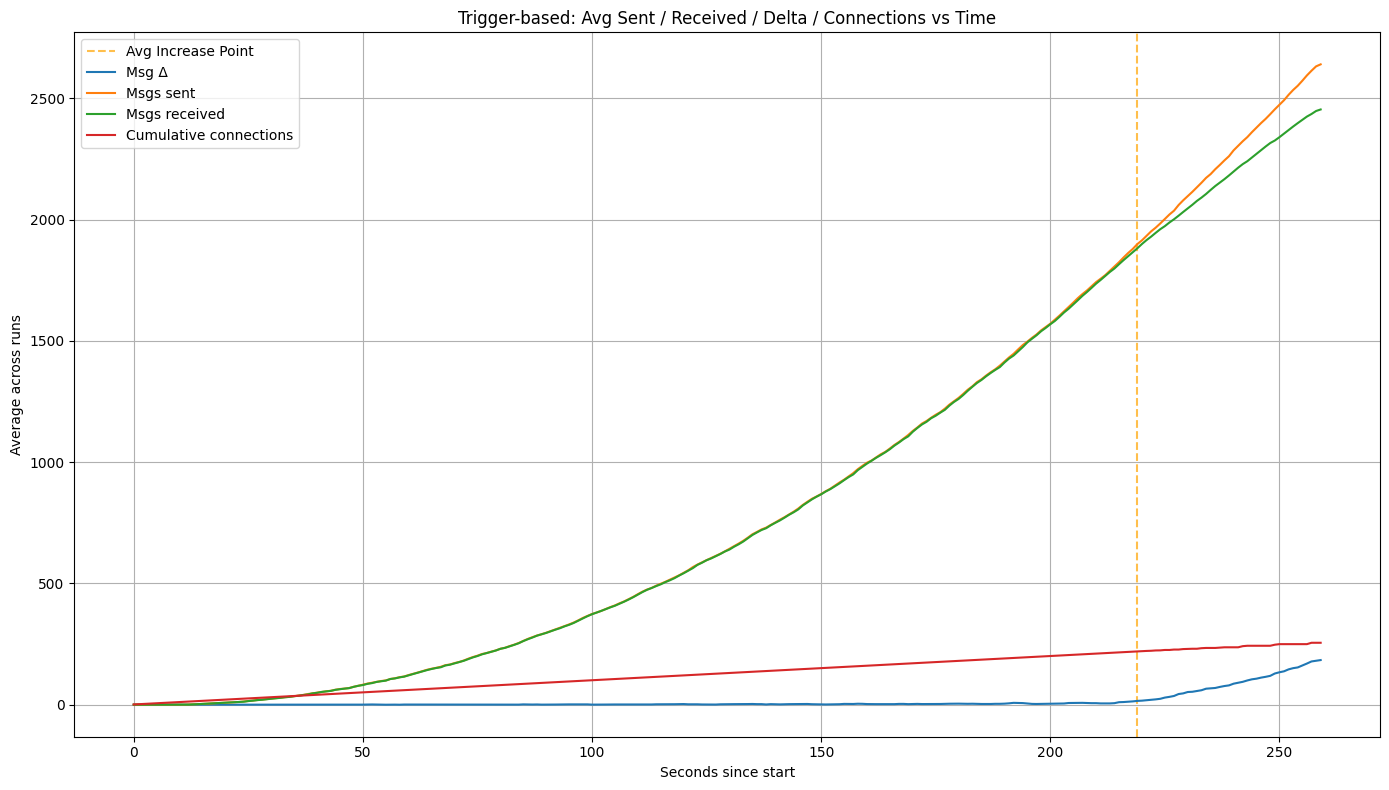

In [ ]:
plt.figure(figsize=(14, 8))

runs = []
increase_points = []
for run_data in raw_runs:
    s = (prepare_dataframe(run_data)
         [['msg_delta', 'sent', 'received', 'connections']]
         .sort_index())
    runs.append(s)
    increase_point = get_increase_point(s)
    # if increase points is not none ge the conncections count for that point
    if increase_point is not None:
        increase_points.append(s['connections'].loc[increase_point])


print(increase_points)

if increase_points:
    avg_increase_point = sum(increase_points) / len(increase_points)
    plt.axvline(x=avg_increase_point, color='orange', linestyle='--', alpha=0.7, label='Avg Increase Point')

comb = pd.concat(runs, axis=1, keys=range(1, len(runs)+1))

avg_delta = comb.xs('msg_delta', axis=1, level=1).mean(axis=1)
avg_sent  = comb.xs('sent', axis=1, level=1).mean(axis=1)
avg_recv  = comb.xs('received', axis=1, level=1).mean(axis=1)
avg_conn  = comb.xs('connections', axis=1, level=1).mean(axis=1)

plt.plot(avg_delta.index, avg_delta.values, label=f'Msg Δ')
plt.plot(avg_sent.index,  avg_sent.values,  label=f'Msgs sent')
plt.plot(avg_recv.index,  avg_recv.values,  label=f'Msgs received')
plt.plot(avg_conn.index,  avg_conn.values,  label=f'Cumulative connections')

plt.xlabel("Seconds since start")
plt.ylabel("Average across runs")
plt.title(f'{method}-based: Avg Sent / Received / Delta / Connections vs Time')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()